In [1]:
!pip install datasets
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer
import math
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from typing import Iterable, List
from tqdm.auto import tqdm
import datasets
import csv
from nltk.translate.bleu_score import sentence_bleu

In [15]:
!pip install transformers datasets evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 10.2 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset
train_dataset = load_dataset("wmt16", "de-en", split="train[:50000]")
validation_dataset = load_dataset("wmt16", "de-en", split="validation")
test_dataset = load_dataset("wmt16", "de-en", split="test")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [7]:
# Printing samples for reference
print(train_dataset[0])
print(len(train_dataset))
print(validation_dataset[0])
print(len(validation_dataset))
print(test_dataset[0])
print(len(test_dataset))

{'translation': {'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}}
50000
{'translation': {'de': 'Die Premierminister Indiens und Japans trafen sich in Tokio.', 'en': 'India and Japan prime ministers meet in Tokyo'}}
2169
{'translation': {'de': 'Obama empfängt Netanyahu', 'en': 'Obama receives Netanyahu'}}
2999


In [8]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    # # inputs = [prefix + text for example in examples["translation"] for text in example[source_lang]]
    # # targets = [text for example in examples["translation"] for text in example[target_lang]]
    model_inputs = tokenizer(inputs, text_target=targets, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    #model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    # return model_inputs
    # source_text = examples['translation']['de']
    # target_text = examples['translation']['en']
    # source_text = "translate German to English: " + source_text
    return model_inputs

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [9]:
trainTokenize = train_dataset.map(preprocess_function, batched = True)
validationTokenize = validation_dataset.map(preprocess_function, batched = True)
testTokenize = test_dataset.map(preprocess_function, batched = True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [10]:
print(trainTokenize[22222])

{'translation': {'de': 'Da wir diese Grundsätze vertreten, können wir die Ziele dieser Richtlinie nicht billigen.', 'en': 'In the light of these principles, we are unable to endorse the aims of this directive.'}, 'input_ids': [13959, 2968, 12, 1566, 10, 878, 558, 637, 4086, 13807, 23547, 6, 730, 558, 67, 5460, 15, 3, 1878, 3, 28180, 311, 2876, 2211, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [11]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [example['input_ids'] for example in batch]
    attention_mask = [example['attention_mask'] for example in batch]
    labels = [example['labels'] for example in batch]
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    labels = torch.tensor(labels)
    # Pad sequences within the batch
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    padded_attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)
    # padded_input_ids = torch.tensor(padded_input_ids)
    # padded_attention_mask = torch.tensor(padded_attention_mask)
    # padded_labels = torch.tensor(padded_labels)
    return {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_mask,
        'labels': padded_labels
    }

In [16]:
import numpy as np, evaluate

metric = evaluate.load("sacrebleu")

def processOutput(preds, labels):
  opreds = []
  olabels = []
  for pred in preds:
    opreds.append(pred.strip())  # Model output processing function for easier evaluation.
  for label in labels:
    olabels.append(label.strip())
  return opreds, olabels

def computeMetric(model_preds):
  preds, labels = model_preds
  if isinstance(preds, tuple):
        preds = preds[0]
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = processOutput(decoded_preds, decoded_labels) # Reformats and processes the predictions made by the model.

  result = metric.compute(predictions=decoded_preds, references=decoded_labels)
  result = {"bleu": result["score"]} # Computing the sacrebleu score of the prediction.

  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
  result["gen_len"] = np.mean(prediction_lens)
  result = {k: round(v, 4) for k, v in result.items()}
  return result

In [17]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
#checkpoint = "google-t5/t5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model.to(DEVICE)
# Loading the pretrained T5 model for fine-tuning.

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [18]:
allLayers = model.named_parameters()
layerNames = [name for name, _ in allLayers]
print(layerNames)

['shared.weight', 'encoder.block.0.layer.0.SelfAttention.q.weight', 'encoder.block.0.layer.0.SelfAttention.k.weight', 'encoder.block.0.layer.0.SelfAttention.v.weight', 'encoder.block.0.layer.0.SelfAttention.o.weight', 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'encoder.block.0.layer.0.layer_norm.weight', 'encoder.block.0.layer.1.DenseReluDense.wi.weight', 'encoder.block.0.layer.1.DenseReluDense.wo.weight', 'encoder.block.0.layer.1.layer_norm.weight', 'encoder.block.1.layer.0.SelfAttention.q.weight', 'encoder.block.1.layer.0.SelfAttention.k.weight', 'encoder.block.1.layer.0.SelfAttention.v.weight', 'encoder.block.1.layer.0.SelfAttention.o.weight', 'encoder.block.1.layer.0.layer_norm.weight', 'encoder.block.1.layer.1.DenseReluDense.wi.weight', 'encoder.block.1.layer.1.DenseReluDense.wo.weight', 'encoder.block.1.layer.1.layer_norm.weight', 'encoder.block.2.layer.0.SelfAttention.q.weight', 'encoder.block.2.layer.0.SelfAttention.k.weight', 'encoder.block.2.layer

In [19]:
finetuneLayers = ["encoder.block.0.layer.0.SelfAttention.q.weight", "encoder.block.0.layer.0.SelfAttention.k.weight", "encoder.block.0.layer.0.SelfAttention.v.weight", "encoder.block.0.layer.0.SelfAttention.o.weight", "encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight", "encoder.block.0.layer.0.layer_norm.weight"]
for name, param in model.named_parameters():
  if name not in finetuneLayers:
    param.requires_grad = False

for name, param in model.named_parameters():
  print(name, param.requires_grad)

shared.weight False
encoder.block.0.layer.0.SelfAttention.q.weight True
encoder.block.0.layer.0.SelfAttention.k.weight True
encoder.block.0.layer.0.SelfAttention.v.weight True
encoder.block.0.layer.0.SelfAttention.o.weight True
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight True
encoder.block.0.layer.0.layer_norm.weight True
encoder.block.0.layer.1.DenseReluDense.wi.weight False
encoder.block.0.layer.1.DenseReluDense.wo.weight False
encoder.block.0.layer.1.layer_norm.weight False
encoder.block.1.layer.0.SelfAttention.q.weight False
encoder.block.1.layer.0.SelfAttention.k.weight False
encoder.block.1.layer.0.SelfAttention.v.weight False
encoder.block.1.layer.0.SelfAttention.o.weight False
encoder.block.1.layer.0.layer_norm.weight False
encoder.block.1.layer.1.DenseReluDense.wi.weight False
encoder.block.1.layer.1.DenseReluDense.wo.weight False
encoder.block.1.layer.1.layer_norm.weight False
encoder.block.2.layer.0.SelfAttention.q.weight False
encoder.block.2.layer.

In [20]:
# Defining the training parameters.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# trainLoader = DataLoader(trainTokenize, batch_size=32, shuffle=True, collate_fn=data_collator)
# validationLoader = DataLoader(validationTokenize, batch_size = 32, shuffle = True, collate_fn=data_collator)
# testLoader = DataLoader(testTokenize, batch_size = 32, shuffle = True, collate_fn=data_collator)
trainLoader = DataLoader(trainTokenize, batch_size=16, shuffle=True, collate_fn=collate_fn)
validationLoader = DataLoader(validationTokenize, batch_size = 16, shuffle = True, collate_fn=collate_fn)
testLoader = DataLoader(testTokenize, batch_size = 16, shuffle = True, collate_fn=collate_fn)
numEpochs = 5

In [ ]:

def train(model, epochs, optimizer, loader):
  lossList = []
  for epoch in range(epochs):
    model.train()
    trainLoss = 0
    for batch in loader:
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(DEVICE)
      #input_ids = [ele.to(DEVICE) for ele in batch['input_ids']]
      attention_mask = batch['attention_mask'].to(DEVICE)
      #attention_mask = [ele2.to(DEVICE) for ele2 in batch['attention_mask']]
      labels = batch['labels'].to(DEVICE)
      #labels = [ele3.to(DEVICE) for ele3 in batch['labels']]
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      #labels = [ele3.to(DEVICE) for ele3 in batch['labels']]
      # inputs_ids = torch.tensor(input_ids)
      # attention_mask = torch.tensor(attention_mask)
      # labels = torch.tensor(labels)

      loss.backward()
      optimizer.step()
      trainLoss = trainLoss + loss.item()

    averageTrainLoss = trainLoss/len(loader)
    lossList.append(averageTrainLoss)
    # Saving the model after every epoch
    print(f"Epoch-{epoch} training completed.")
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, '/content/drive/MyDrive/t5_finetune_ep'+str(epoch)+'.pth')

  return lossList

In [ ]:
trainingLoss = train(model, numEpochs, optimizer, trainLoader)


Epoch-0 training completed.
Epoch-1 training completed.
Epoch-2 training completed.
Epoch-3 training completed.
Epoch-4 training completed.


In [ ]:
def load_model(model, optim, file_name):
    checkpoint = torch.load(file_name, map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint["model_state_dict"])
    optim.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"]

In [ ]:
def computeValLoss(model, loader, optimizer):
  valLoss = []
  for ep in range(5):
    in_mod = '/content/drive/MyDrive/t5_finetune_ep'+str(ep)+'.pth'
    checkpoint = torch.load(in_mod, map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()
    curLoss = 0
    for batch in loader:
      with torch.no_grad():
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        curLoss = curLoss + loss.item()

    avgLoss = curLoss/len(loader)
    valLoss.append(avgLoss)
  return valLoss



In [ ]:
validationLoss = computeValLoss(model, validationLoader, optimizer)


In [ ]:
print(trainingLoss)
print(validationLoss)

[0.6823349729442596, 0.6736604313755036, 0.6666346706581115, 0.6616880396747589, 0.6568648714256287]
[0.5439467682119679, 0.5444473944166127, 0.5401080222252537, 0.5325177158502972, 0.5376112866489327]


In [21]:
trainingLoss = [0.6823349729442596, 0.6736604313755036, 0.6666346706581115, 0.6616880396747589, 0.6568648714256287]
validationLoss = [0.5439467682119679, 0.5444473944166127, 0.5401080222252537, 0.5325177158502972, 0.5376112866489327]
for i in range(len(trainingLoss)):
  trainingLoss[i] = trainingLoss[i]*len(trainLoader)
  trainingLoss[i] = trainingLoss[i]/(i+1)

for i in range(len(validationLoss)):
  validationLoss[i] = validationLoss[i]*len(validationLoader)
  validationLoss[i] = validationLoss[i]/(i+1)

print(trainingLoss)
print(validationLoss)


[2132.2967904508114, 1052.5944240242243, 694.4111152688662, 516.9437809959054, 410.5405446410179]
[73.97676047682762, 37.022422820329666, 24.484897007544834, 18.105602338910103, 14.623026996850967]


In [22]:
import matplotlib.pyplot as plt
def plotLoss(lossList, lossName):
  epochs = [1,2,3,4,5]
  plt.plot(epochs, lossList, marker='o', color='b', linestyle='-')
  plt.xlabel('Epoch Number')
  plt.ylabel(f'{lossName} Loss')
  plt.title(f'{lossName} Loss vs. Epoch Number')
  plt.grid(True)
  plt.tight_layout()
  plt.show()


############## PLOTTING THE TRAINING LOSS VS EPOCH CURVE #####################


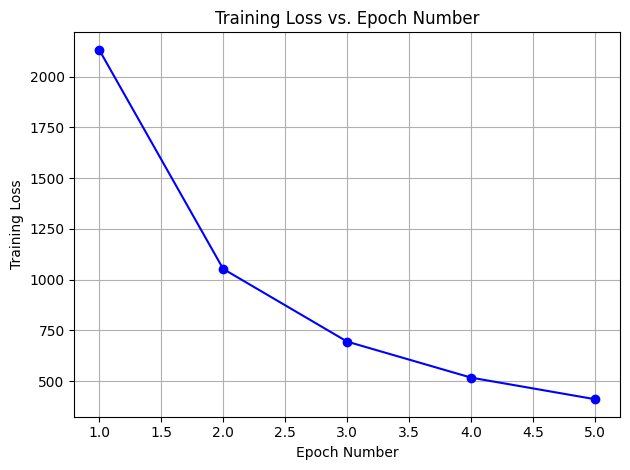

In [23]:
print("############## PLOTTING THE TRAINING LOSS VS EPOCH CURVE #####################")
plotLoss(trainingLoss, "Training")

############## PLOTTING THE VALIDATION LOSS VS EPOCH CURVE #####################


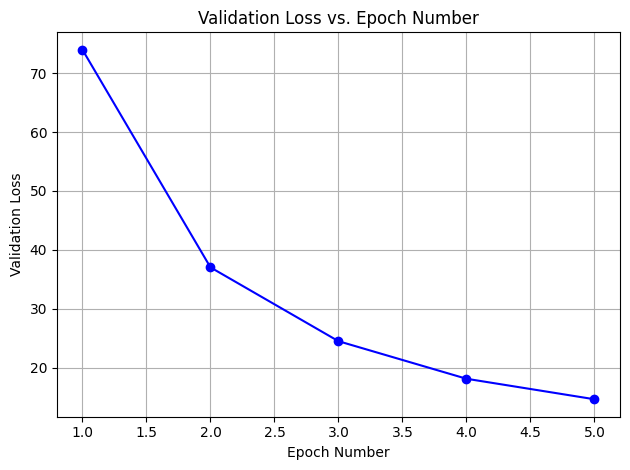

In [24]:
print("############## PLOTTING THE VALIDATION LOSS VS EPOCH CURVE #####################")
plotLoss(validationLoss, "Validation")

In [28]:
from transformers import pipeline
modelPath = "/content/drive/MyDrive/t5_finetune_ep4.pth"
checkpoint = torch.load(modelPath, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")
transPipe = pipeline("translation_de_to_en", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [36]:
# tempo = transPipe(["Das ist ein Beispieltext auf Deutsch.", "Ich weiß jetzt, dass ich es tun kann - brillant!"])
# print(tempo[1]["translation_text"])
validationResults = transPipe([sentence["translation"]["de"] for sentence in validation_dataset], max_length=512, num_beams=4, early_stopping=True)
# print(validationResults[0]["translation_text"])
# print(validationResults[1]["translation_text"])
testResults = transPipe([sentence["translation"]["de"] for sentence in test_dataset], max_length=512, num_beams=4, early_stopping=True)

In [37]:
print("Validation Set Translations:")
for i in range(len(validation_dataset)):
    print("Source (German):", validation_dataset[i]["translation"]["de"])
    print("Translation (English):", validationResults[i]["translation_text"])

Validation Set Translations:
Source (German): Die Premierminister Indiens und Japans trafen sich in Tokio.
Translation (English): The Prime Minister Indien and Japan trafen in Tokio.
Source (German): Indiens neuer Premierminister Narendra Modi trifft bei seinem ersten wichtigen Auslandsbesuch seit seinem Wahlsieg im Mai seinen japanischen Amtskollegen Shinzo Abe in Toko, um wirtschaftliche und sicherheitspolitische Beziehungen zu besprechen.
Translation (English): Premier Minister Narendra Modi is in Toko for his first important foreign visit since his election in Mai, in which he will visit his japane Amtskol Shinzo Abe in Toko, to discuss economic and security political relations.
Source (German): Herr Modi befindet sich auf einer fünftägigen Reise nach Japan, um die wirtschaftlichen Beziehungen mit der drittgrößten Wirtschaftsnation der Welt zu festigen.
Translation (English): Mr Modi is on a five-month trip to Japan, in order to establish economic relations with the third largest e

In [38]:
print("Test Set Translations:")
for i in range(len(test_dataset)):
    print("Source (German):", test_dataset[i]["translation"]["de"])
    print("Translation (English):", testResults[i]["translation_text"])

Streaming output truncated to the last 5000 lines.
Source (German): Bei all diesen Messungen hat etwa ein Viertel der demokratischen Wähler keine Meinung von Sanders.
Translation (English): Bei all diesen Messungen hat etwa a quarter of a democratic electrist has no opinion of Sanders.
Source (German): Da Fragen zu Hillary Clintons Verwendung einer persönlichen E-Mail-Adresse und eines Servers während der Amtszeit als Außenministerin weiterhin gestellt werden, sind die meisten Demokratischen Wähler der Vorwahlen zufrieden mit ihrer Erklärung der Angelegenheit und sagen, dass es ihre Meinungen insgesamt nicht beeinflusst hat.
Translation (English): Da Hillary Clinton weiterhin eine persönliche E-Mail-Adresse und einen Server während der Amtszeit als Außenminister gestellt werden, sind die meisten Demokratic Wähler in den Vorwahlen zufrieden mit ihrer Erklärung der Angelegenheit und sagen, dass ihre Meinung insgesamt nicht flusst.
Source (German): Aber es ist eine andere Geschichte in de

In [39]:
import pickle
with open('/content/drive/MyDrive/lists2.pkl', 'wb') as f:
    pickle.dump((validationResults, testResults), f)

In [40]:
import pickle
with open('/content/drive/MyDrive/lists2.pkl', 'rb') as f:
    validationResults, testResults = pickle.load(f)

# Print loaded lists
print("List 1:", validationResults[2168]["translation_text"])
print("List 2:", testResults[2998]["translation_text"])

List 1: Für nächste Jahr hofft, dass es gelingt, sperren the route to fieldberg for safety of participants.
List 2: Foodwatch ruft Verbraucher zum Protest gegen die EU-Pläne auf, unter www.quecksilber-aktion.foodwatch.de.


In [41]:
##### FOR DEMO PURPOSES ###############
demoTest = transPipe(["Mein Name ist Rohan Gupta", "Dies ist die NLP-Zuweisung 3."], max_length=512, num_beams=4, early_stopping=True)
for i in range(len(demoTest)):
  print(demoTest[i]["translation_text"])

My name is Rohan Gupta
This is the NLP-Zuweisung 3.


In [42]:
!pip install transformers datasets evaluate sacrebleu
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


In [45]:
########## CALCULATING EVALUATION METRICS #######################
references = []
predictions = []
for i in range(len(test_dataset)):
  references.append(test_dataset[i]["translation"]["en"])
  predictions.append(testResults[i]["translation_text"])

from evaluate import load
bertT = load("bertscore")
meteorT = load('meteor')
bleuT = load("bleu", max_order=1)
bleuT2 = load("bleu", max_order=2)
bleuT3 = load("bleu", max_order=3)
bleuT4 = load("bleu", max_order=4)

#bertR = bertT.compute(predictions=predictions, references=references, lang="de")
meteorR = meteorT.compute(predictions=predictions, references=references)
bleuR = bleuT.compute(predictions=predictions, references=references, max_order=1)
bleuR2 = bleuT2.compute(predictions=predictions, references=references, max_order=2)
bleuR3 = bleuT3.compute(predictions=predictions, references=references, max_order=3)
bleuR4 = bleuT4.compute(predictions=predictions, references=references, max_order=4)

#print("BertScore is: ", bertR)
print("Meteor Score is: ", meteorR)
print("Bleu-1 Score is: ", bleuR)
print("Bleu-2 Score is: ", bleuR2)
print("Bleu-3 Score is: ", bleuR3)
print("Bleu-4 Score is: ", bleuR4)

# bertR = bertT.compute(predictions=predictions, references=references, lang="de")
# print("BertScore is: ", bertR)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Meteor Score is:  {'meteor': 0.32253309508459693}
Bleu-1 Score is:  {'bleu': 0.3752247078396149, 'precisions': [0.38373835948462814], 'brevity_penalty': 0.9778139155635956, 'length_ratio': 0.9780564263322884, 'translation_length': 62712, 'reference_length': 64119}
Bleu-2 Score is:  {'bleu': 0.2431247493358488, 'precisions': [0.38373835948462814, 0.1611056235455626], 'brevity_penalty': 0.9778139155635956, 'length_ratio': 0.9780564263322884, 'translation_length': 62712, 'reference_length': 64119}
Bleu-3 Score is:  {'bleu': 0.16746884388235378, 'precisions': [0.38373835948462814, 0.1611056235455626, 0.08126200081032994], 'brevity_penalty': 0.9778139155635956, 'length_ratio': 0.9780564263322884, 'translation_length': 62712, 'reference_length': 64119}
Bleu-4 Score is:  {'bleu': 0.11874342128344316, 'precisions': [0.38373835948462814, 0.1611056235455626, 0.08126200081032994, 0.04328923900118906], 'brevity_penalty': 0.9778139155635956, 'length_ratio': 0.9780564263322884, 'translation_length':

In [49]:
import pandas as pd
print("########### CSV DEMO PIPELINE ################")
df = pd.read_csv("/content/drive/MyDrive/t5trial2.csv")
german_sentences = df["de"].tolist()
english_sentences = [transPipe(sentence, max_length=512, num_beams=4, early_stopping=True)[0]["translation_text"] for sentence in german_sentences]
translated_df = pd.DataFrame({"de": german_sentences, "en": english_sentences})
translated_df.to_csv("/content/drive/MyDrive/translated_sentences_partc.csv", index=False)

########### CSV DEMO PIPELINE ################
